IMPORT LIBRARY

In [ ]:
# Import library
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

!pip install spacy
!python -m spacy download xx_ent_wiki_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 68.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


DATA COLLECTION

In [ ]:
# Load dataset
df = pd.read_csv('/content/news_sentiment_analysis.csv')

# Display the first few rows of the dataset
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3500 non-null   object
 1   Author        2512 non-null   object
 2   Title         3500 non-null   object
 3   Description   3500 non-null   object
 4   URL           3500 non-null   object
 5   Published At  3500 non-null   object
 6   Sentiment     3500 non-null   object
 7   Type          3500 non-null   object
dtypes: object(8)
memory usage: 218.9+ KB


DATA PREPROCESSING

In [ ]:
# Mengecek missing value di setiap kolom
print("Missing Values:")
print(df.isnull().sum())

# Mengecek jumlah duplikat
print("\nJumlah data duplikat:")
print(df.duplicated().sum())

# Menampilkan data duplikat (jika ingin melihat baris duplikat)
print("\nContoh data duplikat:")
print(df[df.duplicated()].head())


Missing Values:
Source            0
Author          988
Title             0
Description       0
URL               0
Published At      0
Sentiment         0
Type              0
dtype: int64

Jumlah data duplikat:
737

Contoh data duplikat:
                                                Source              Author  \
895                                 Essentially Sports   Shrabana Sengupta   
896                                 Essentially Sports        Rupam Shukla   
897                                           Castanet  The Canadian Press   
898                                      cagesideseats            M. G0MEZ   
899  Investing.com | Stock Market Quotes &amp; Fina...       Investing.com   

                                                 Title  \
895  Mastermind Behind WWE’s Netflix Deal Predicts ...   
896  Tennis Rumour: Barbora Krejcikova Gets Excited...   
897  Alec Baldwin's involuntary manslaughter case d...   
898  WWE’s return to Mexico City sparks nostalgia f...   
89

In [ ]:
# Menghapus baris duplikat (opsional)
df = df.drop_duplicates()

In [ ]:
texts = df['Description']
labels = df['Sentiment']

In [ ]:
stopwords_indonesia = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\@[\w]+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabet characters
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_indonesia]  # Remove stopwords
    return " ".join(tokens)

# Clean the text data
df['cleaned_text'] = texts.apply(clean_text)



EXPLORATORY DATA ANALYSIS

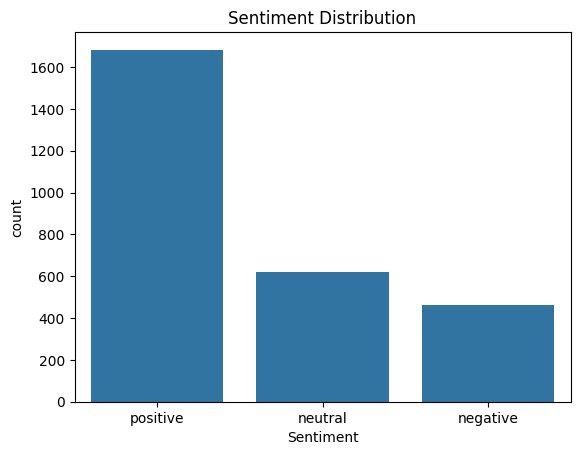

In [ ]:
# Sentiment distribution visualization (positive vs negative)
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()


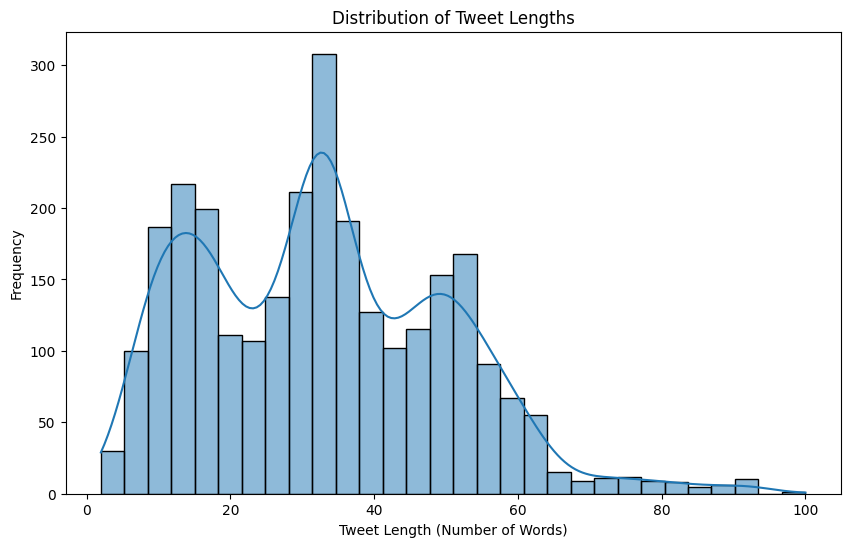

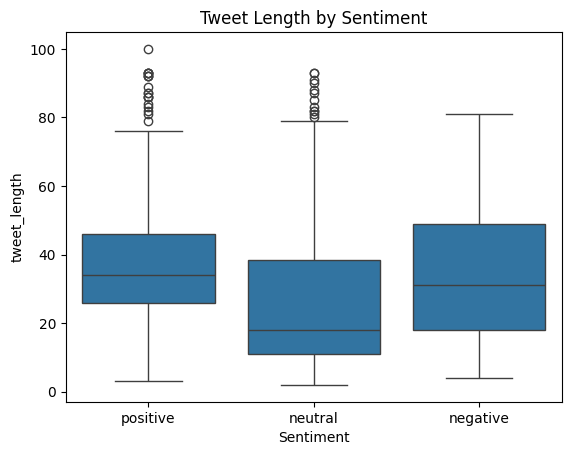

In [ ]:
# Add tweet length as a new column
df['tweet_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Plot histogram of tweet length
plt.figure(figsize=(10,6))
sns.histplot(df['tweet_length'], kde=True, bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Check if negative tweets tend to be longer than positive ones
sns.boxplot(x='Sentiment', y='tweet_length', data=df)
plt.title('Tweet Length by Sentiment')
plt.show()

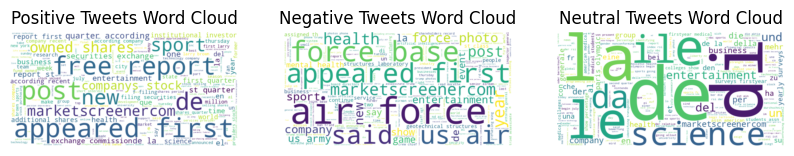

In [ ]:
from wordcloud import WordCloud

# Separate positive and negative tweets
positive_tweets = ' '.join(df[df['Sentiment'] == 'positive']['cleaned_text'])
negative_tweets = ' '.join(df[df['Sentiment'] == 'negative']['cleaned_text'])
neutral_tweets = ' '.join(df[df['Sentiment'] == 'neutral']['cleaned_text'])

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)
neutral_wc = WordCloud(width=800, height=400, background_color='white').generate(neutral_tweets)

# Display word clouds
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wc, interpolation='bilinear')
plt.title('Neutral Tweets Word Cloud')
plt.axis('off')

plt.show()

{'VERB': 0.0, 'ADJ': 0.0, 'ADV': 0.0}


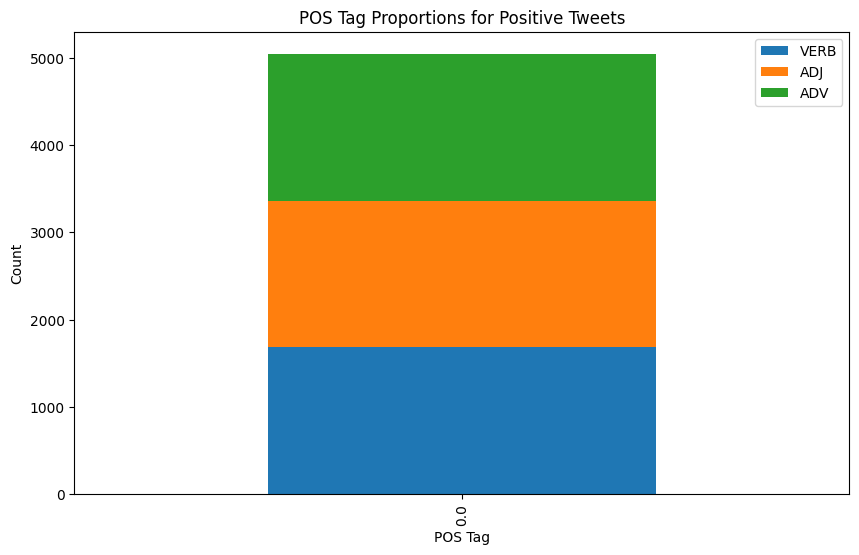

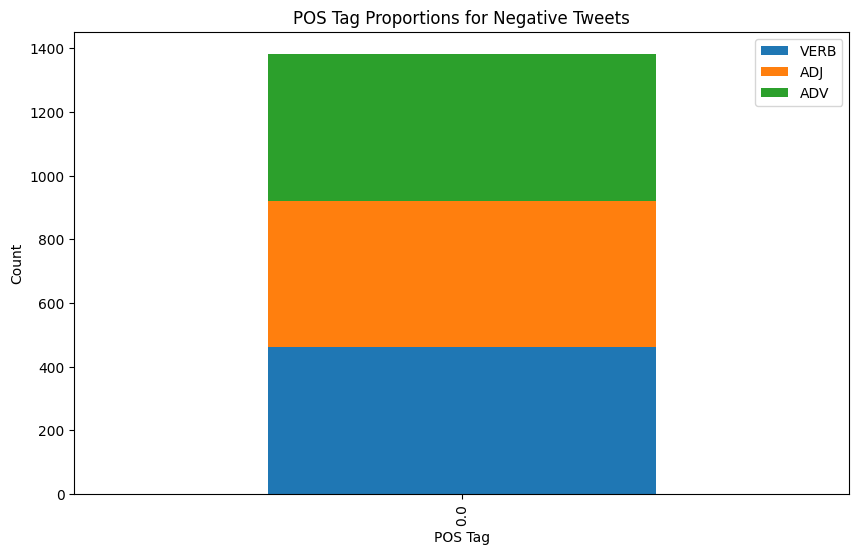

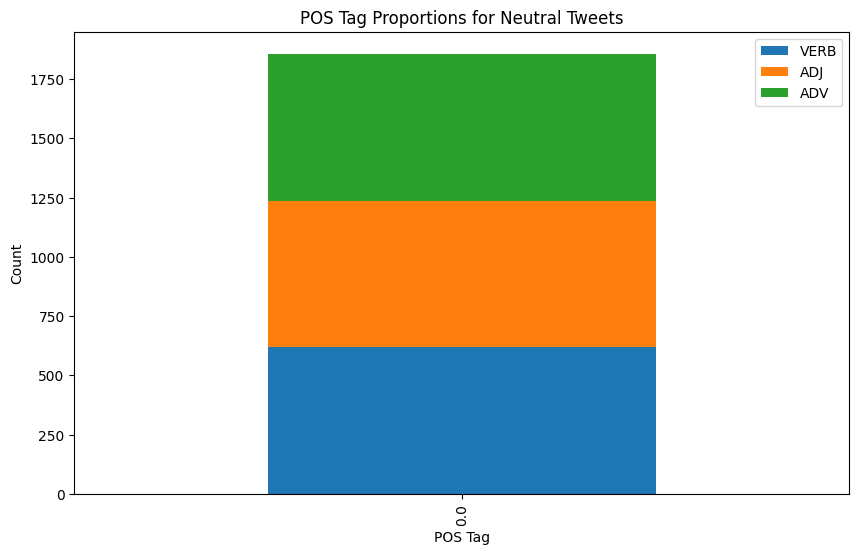

In [ ]:
import spacy

# Load spaCy's multilingual model
nlp = spacy.load('xx_ent_wiki_sm')

# Function to calculate POS proportions
def pos_tagging(text):
    doc = nlp(text)
    pos_counts = {'VERB': 0, 'ADJ': 0, 'ADV': 0}

    for token in doc:
        if token.pos_ == 'VERB':
            pos_counts['VERB'] += 1
        elif token.pos_ == 'ADJ':
            pos_counts['ADJ'] += 1
        elif token.pos_ == 'ADV':
            pos_counts['ADV'] += 1

    total_tokens = len(doc)
    pos_proportions = {pos: count / total_tokens for pos, count in pos_counts.items()}
    return pos_proportions

# Example POS tagging
text = "Saya sangat senang menonton film ini!"
pos_proportions = pos_tagging(text)
print(pos_proportions)


# Apply POS tagging and get proportions
df['pos_tags'] = df['cleaned_text'].apply(pos_tagging)

# Get proportions of POS tags for positive and negative tweets
positive_pos_tags = df[df['Sentiment'] == 'positive']['pos_tags']
negative_pos_tags = df[df['Sentiment'] == 'negative']['pos_tags']
neutral_pos_tags = df[df['Sentiment'] == 'neutral']['pos_tags']

# Summarize POS proportions
positive_pos_tags_summary = pd.DataFrame(positive_pos_tags.tolist()).apply(pd.Series.value_counts).fillna(0)
negative_pos_tags_summary = pd.DataFrame(negative_pos_tags.tolist()).apply(pd.Series.value_counts).fillna(0)
neutral_pos_tags_summary = pd.DataFrame(neutral_pos_tags.tolist()).apply(pd.Series.value_counts).fillna(0)

positive_pos_tags_summary.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('POS Tag Proportions for Positive Tweets')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()

negative_pos_tags_summary.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('POS Tag Proportions for Negative Tweets')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()

neutral_pos_tags_summary.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('POS Tag Proportions for Neutral Tweets')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()

DIMENSIONALITY REDUCTION WITH PCA

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# Langsung ke PCA (tanpa StandardScaler karena TF-IDF sudah normalized)
pca = PCA()
X_tfidf_array = X_tfidf.toarray()  # PCA butuh array
pca.fit(X_tfidf_array)

# Hitung kumulatif variansi
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Cari jumlah komponen untuk >95% variansi
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Cetak hasil
print(f"Jumlah komponen yang dibutuhkan untuk menjelaskan 95% variansi: {n_components_95}")
print("Variansi kumulatif sampai komponen tersebut:", cumulative_variance[:n_components_95])

Jumlah komponen yang dibutuhkan untuk menjelaskan 95% variansi: 1807
Variansi kumulatif sampai komponen tersebut: [0.01735375 0.0280249  0.03700456 ... 0.94970727 0.9498771  0.9500467 ]


In [ ]:
# Mendapatkan semua fitur (kata-kata) yang digunakan dalam model TF-IDF
features = vectorizer.get_feature_names_out()

# Menampilkan jumlah total kata (fitur) yang digunakan sebelum PCA
print(f"Jumlah total kata (fitur) sebelum PCA: {len(features)}")

Jumlah total kata (fitur) sebelum PCA: 19629


In [ ]:
# PCA Reduction
pca = PCA(n_components=1807)
X_pca = pca.fit_transform(X_tfidf.toarray())

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# Perform feature selection using Mutual Information
ig_scores = mutual_info_classif(X_pca, labels)
best_component_idx = np.argmax(ig_scores)
X_selected = X_pca[:, best_component_idx].reshape(-1, 1)

MODELING DAN EVALUASI

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, labels, test_size=0.3, random_state=42)

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)

KNN SEBELUM PCA

In [ ]:
# Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate model with 70/30 split
acc_split_knn = accuracy_score(y_test, y_pred) * 100
prec_split_knn = precision_score(y_test, y_pred, average='macro') * 100
recall_split_knn = recall_score(y_test, y_pred, average='macro') * 100
f1_split_knn = f1_score(y_test, y_pred, average='macro') * 100

print("\n=== Evaluasi KNN dengan Split 70/30 ===\n")
print(f"Akurasi : {acc_split_knn:.2f}%")
print(f"Presisi : {prec_split_knn:.2f}%")
print(f"Recall  : {recall_split_knn:.2f}%")
print(f"F1-Score: {f1_split_knn:.2f}%")


=== Evaluasi KNN dengan Split 70/30 ===

Akurasi : 62.36%
Presisi : 52.83%
Recall  : 51.25%
F1-Score: 51.83%


In [ ]:
# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation results for different metrics
acc_cv_knn = cross_val_score(knn, X_selected, labels, cv=cv, scoring='accuracy').mean() * 100
prec_cv_knn = cross_val_score(knn, X_selected, labels, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_knn = cross_val_score(knn, X_selected, labels, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_knn = cross_val_score(knn, X_selected, labels, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi KNN dengan 10-Fold Cross Validation ===\n")
print(f"Akurasi : {acc_cv_knn:.2f}%")
print(f"Presisi : {prec_cv_knn:.2f}%")
print(f"Recall  : {recall_cv_knn:.2f}%")
print(f"F1-Score: {f1_cv_knn:.2f}%")


=== Evaluasi KNN dengan 10-Fold Cross Validation ===

Akurasi : 61.92%
Presisi : 52.45%
Recall  : 49.87%
F1-Score: 50.72%


KNN SESUDAH PCA

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize KNN model
knn_pca = KNeighborsClassifier(n_neighbors=5)

# Train the model on PCA-reduced data
knn_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = knn_pca.predict(X_test_pca)

# Evaluate model with 70/30 split on PCA data
acc_split_knn_pca = accuracy_score(y_test_pca, y_pred_pca) * 100
prec_split_knn_pca = precision_score(y_test_pca, y_pred_pca, average='macro') * 100
recall_split_knn_pca = recall_score(y_test_pca, y_pred_pca, average='macro') * 100
f1_split_knn_pca = f1_score(y_test_pca, y_pred_pca, average='macro') * 100

print("\n=== Evaluasi KNN dengan PCA (Split 70/30) ===\n")
print(f"Akurasi : {acc_split_knn_pca:.2f}%")
print(f"Presisi : {prec_split_knn_pca:.2f}%")
print(f"Recall  : {recall_split_knn_pca:.2f}%")
print(f"F1-Score: {f1_split_knn_pca:.2f}%")



=== Evaluasi KNN dengan PCA (Split 70/30) ===

Akurasi : 69.36%
Presisi : 62.10%
Recall  : 59.33%
F1-Score: 60.48%


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Gunakan data PCA hasil reduksi
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation dengan PCA
acc_cv_knn_pca = cross_val_score(knn_pca, X_pca, y, cv=cv, scoring='accuracy').mean() * 100
prec_cv_knn_pca = cross_val_score(knn_pca, X_pca, y, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_knn_pca = cross_val_score(knn_pca, X_pca, y, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_knn_pca = cross_val_score(knn_pca, X_pca, y, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi KNN dengan PCA (10-Fold Cross Validation) ===\n")
print(f"Akurasi : {acc_cv_knn_pca:.2f}%")
print(f"Presisi : {prec_cv_knn_pca:.2f}%")
print(f"Recall  : {recall_cv_knn_pca:.2f}%")
print(f"F1-Score: {f1_cv_knn_pca:.2f}%")


=== Evaluasi KNN dengan PCA (10-Fold Cross Validation) ===

Akurasi : 70.07%
Presisi : 64.48%
Recall  : 60.97%
F1-Score: 62.15%


SVM SEBELUM PCA

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize SVM model
svm = SVC(kernel='rbf')  # kamu juga bisa pakai 'linear', 'poly', dll

# Train the model
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate model with 70/30 split
acc_split_svm = accuracy_score(y_test, y_pred) * 100
prec_split_svm = precision_score(y_test, y_pred, average='macro') * 100
recall_split_svm = recall_score(y_test, y_pred, average='macro') * 100
f1_split_svm = f1_score(y_test, y_pred, average='macro') * 100

print("\n=== Evaluasi SVM dengan Split 70/30 ===\n")
print(f"Akurasi : {acc_split_svm:.2f}%")
print(f"Presisi : {prec_split_svm:.2f}%")
print(f"Recall  : {recall_split_svm:.2f}%")
print(f"F1-Score: {f1_split_svm:.2f}%")


=== Evaluasi SVM dengan Split 70/30 ===

Akurasi : 62.97%
Presisi : 55.03%
Recall  : 36.51%
F1-Score: 32.76%


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize SVM model
svm = SVC(kernel='rbf', random_state=42)  # Kamu bisa ganti kernel sesuai kebutuhan

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation results for different metrics
acc_cv_svm = cross_val_score(svm, X_selected, labels, cv=cv, scoring='accuracy').mean() * 100
prec_cv_svm = cross_val_score(svm, X_selected, labels, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_svm = cross_val_score(svm, X_selected, labels, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_svm = cross_val_score(svm, X_selected, labels, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi SVM dengan 10-Fold Cross Validation ===\n")
print(f"Akurasi : {acc_cv_svm:.2f}%")
print(f"Presisi : {prec_cv_svm:.2f}%")
print(f"Recall  : {recall_cv_svm:.2f}%")
print(f"F1-Score: {f1_cv_svm:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


=== Evaluasi SVM dengan 10-Fold Cross Validation ===

Akurasi : 61.96%
Presisi : 49.35%
Recall  : 35.85%
F1-Score: 30.66%


SVM SESUDAH PCA

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize SVM model (bisa ganti kernel ke 'linear', 'poly', dsb jika ingin)
svm_pca = SVC(kernel='rbf')

# Train the model on PCA-reduced data
svm_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = svm_pca.predict(X_test_pca)

# Evaluate model with 70/30 split on PCA data
acc_split_svm_pca = accuracy_score(y_test_pca, y_pred_pca) * 100
prec_split_svm_pca = precision_score(y_test_pca, y_pred_pca, average='macro') * 100
recall_split_svm_pca = recall_score(y_test_pca, y_pred_pca, average='macro') * 100
f1_split_svm_pca = f1_score(y_test_pca, y_pred_pca, average='macro') * 100

print("\n=== Evaluasi SVM dengan PCA (Split 70/30) ===\n")
print(f"Akurasi : {acc_split_svm_pca:.2f}%")
print(f"Presisi : {prec_split_svm_pca:.2f}%")
print(f"Recall  : {recall_split_svm_pca:.2f}%")
print(f"F1-Score: {f1_split_svm_pca:.2f}%")


=== Evaluasi SVM dengan PCA (Split 70/30) ===

Akurasi : 78.17%
Presisi : 85.83%
Recall  : 62.71%
F1-Score: 68.43%


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Gunakan data hasil PCA
svm_pca = SVC(kernel='rbf', random_state=42)

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation dengan data hasil PCA
acc_cv_svm_pca = cross_val_score(svm_pca, X_pca, y, cv=cv, scoring='accuracy').mean() * 100
prec_cv_svm_pca = cross_val_score(svm_pca, X_pca, y, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_svm_pca = cross_val_score(svm_pca, X_pca, y, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_svm_pca = cross_val_score(svm_pca, X_pca, y, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi SVM dengan PCA (10-Fold Cross Validation) ===\n")
print(f"Akurasi : {acc_cv_svm_pca:.2f}%")
print(f"Presisi : {prec_cv_svm_pca:.2f}%")
print(f"Recall  : {recall_cv_svm_pca:.2f}%")
print(f"F1-Score: {f1_cv_svm_pca:.2f}%")


=== Evaluasi SVM dengan PCA (10-Fold Cross Validation) ===

Akurasi : 77.42%
Presisi : 86.34%
Recall  : 61.95%
F1-Score: 67.19%


NAIVE BAYES SEBELUM PCA

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize Naive Bayes model
nb = GaussianNB()

# Train the model
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Evaluate model with 70/30 split
acc_split_nb = accuracy_score(y_test, y_pred) * 100
prec_split_nb = precision_score(y_test, y_pred, average='macro') * 100
recall_split_nb = recall_score(y_test, y_pred, average='macro') * 100
f1_split_nb = f1_score(y_test, y_pred, average='macro') * 100

print("\n=== Evaluasi Naive Bayes dengan Split 70/30 ===\n")
print(f"Akurasi : {acc_split_nb:.2f}%")
print(f"Presisi : {prec_split_nb:.2f}%")
print(f"Recall  : {recall_split_nb:.2f}%")
print(f"F1-Score: {f1_split_nb:.2f}%")



=== Evaluasi Naive Bayes dengan Split 70/30 ===

Akurasi : 62.12%
Presisi : 20.71%
Recall  : 33.33%
F1-Score: 25.55%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize Naive Bayes model
nb = GaussianNB()

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation results for different metrics
acc_cv_nb = cross_val_score(nb, X_selected, labels, cv=cv, scoring='accuracy').mean() * 100
prec_cv_nb = cross_val_score(nb, X_selected, labels, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_nb = cross_val_score(nb, X_selected, labels, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_nb = cross_val_score(nb, X_selected, labels, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi Naive Bayes dengan 10-Fold Cross Validation ===\n")
print(f"Akurasi : {acc_cv_nb:.2f}%")
print(f"Presisi : {prec_cv_nb:.2f}%")
print(f"Recall  : {recall_cv_nb:.2f}%")
print(f"F1-Score: {f1_cv_nb:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


=== Evaluasi Naive Bayes dengan 10-Fold Cross Validation ===

Akurasi : 60.91%
Presisi : 20.30%
Recall  : 33.33%
F1-Score: 25.24%


NAIVE BAYES SESUDAH PCA

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Naive Bayes model
nb_pca = GaussianNB()

# Train the model on PCA-reduced data
nb_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = nb_pca.predict(X_test_pca)

# Evaluate model with 70/30 split on PCA data
acc_split_nb_pca = accuracy_score(y_test_pca, y_pred_pca) * 100
prec_split_nb_pca = precision_score(y_test_pca, y_pred_pca, average='macro') * 100
recall_split_nb_pca = recall_score(y_test_pca, y_pred_pca, average='macro') * 100
f1_split_nb_pca = f1_score(y_test_pca, y_pred_pca, average='macro') * 100

print("\n=== Evaluasi Naive Bayes dengan PCA (Split 70/30) ===\n")
print(f"Akurasi : {acc_split_nb_pca:.2f}%")
print(f"Presisi : {prec_split_nb_pca:.2f}%")
print(f"Recall  : {recall_split_nb_pca:.2f}%")
print(f"F1-Score: {f1_split_nb_pca:.2f}%")


=== Evaluasi Naive Bayes dengan PCA (Split 70/30) ===

Akurasi : 64.41%
Presisi : 57.13%
Recall  : 55.82%
F1-Score: 56.21%


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Naive Bayes model
nb_pca = GaussianNB()

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation dengan data hasil PCA
acc_cv_nb_pca = cross_val_score(nb_pca, X_pca, y, cv=cv, scoring='accuracy').mean() * 100
prec_cv_nb_pca = cross_val_score(nb_pca, X_pca, y, cv=cv, scoring='precision_macro').mean() * 100
recall_cv_nb_pca = cross_val_score(nb_pca, X_pca, y, cv=cv, scoring='recall_macro').mean() * 100
f1_cv_nb_pca = cross_val_score(nb_pca, X_pca, y, cv=cv, scoring='f1_macro').mean() * 100

print("\n=== Evaluasi SVM dengan PCA (10-Fold Cross Validation) ===\n")
print(f"Akurasi : {acc_cv_nb_pca:.2f}%")
print(f"Presisi : {prec_cv_nb_pca:.2f}%")
print(f"Recall  : {recall_cv_nb_pca:.2f}%")
print(f"F1-Score: {f1_cv_nb_pca:.2f}%")


=== Evaluasi SVM dengan PCA (10-Fold Cross Validation) ===

Akurasi : 61.85%
Presisi : 54.13%
Recall  : 53.71%
F1-Score: 53.71%


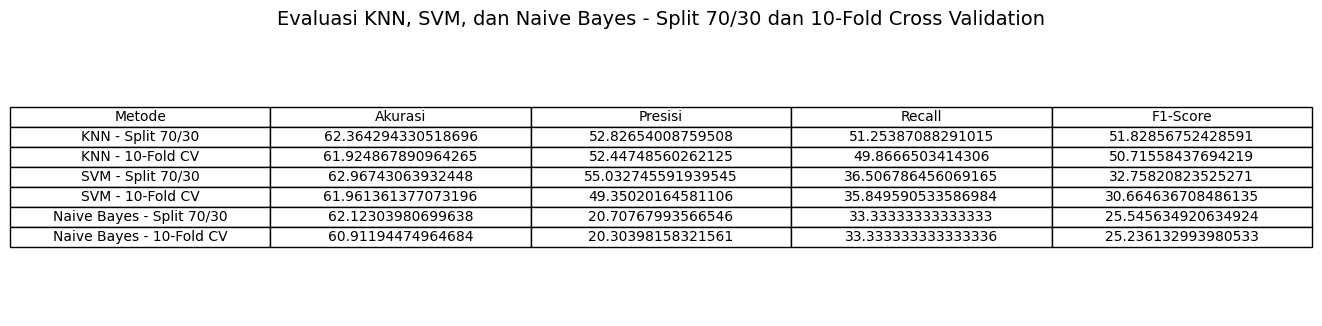

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Buat DataFrame hasil evaluasi semua metode
results = pd.DataFrame({
    'Metode': [
        'KNN - Split 70/30', 'KNN - 10-Fold CV',
        'SVM - Split 70/30', 'SVM - 10-Fold CV',
        'Naive Bayes - Split 70/30', 'Naive Bayes - 10-Fold CV'
    ],
    'Akurasi': [
        acc_split_knn, acc_cv_knn,
        acc_split_svm, acc_cv_svm,
        acc_split_nb, acc_cv_nb
    ],
    'Presisi': [
        prec_split_knn, prec_cv_knn,
        prec_split_svm, prec_cv_svm,
        prec_split_nb, prec_cv_nb
    ],
    'Recall': [
        recall_split_knn, recall_cv_knn,
        recall_split_svm, recall_cv_svm,
        recall_split_nb, recall_cv_nb
    ],
    'F1-Score': [
        f1_split_knn, f1_cv_knn,
        f1_split_svm, f1_cv_svm,
        f1_split_nb, f1_cv_nb
    ]
})

# Fungsi untuk menampilkan tabel evaluasi
def plot_table(dataframe, title):
    fig, ax = plt.subplots(figsize=(14, len(dataframe)*0.6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=10)
    plt.show()

# Tampilkan tabel evaluasi semua model
plot_table(results, "Evaluasi KNN, SVM, dan Naive Bayes - Split 70/30 dan 10-Fold Cross Validation")


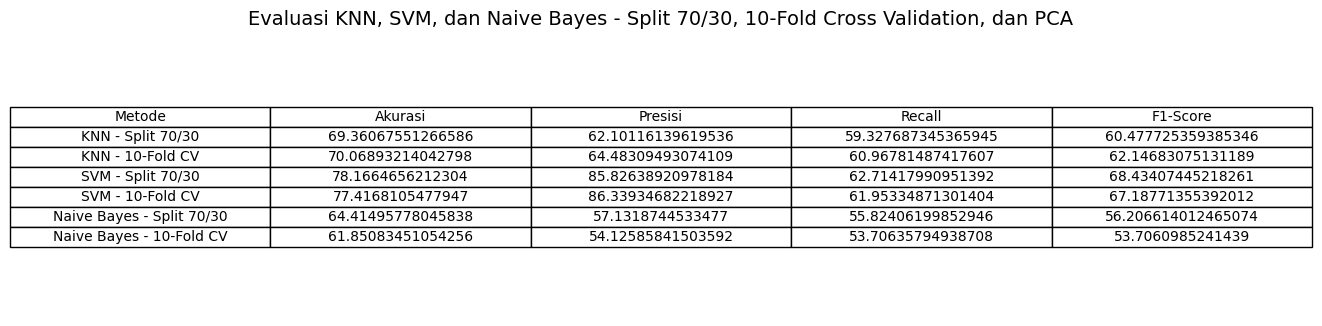

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Buat DataFrame hasil evaluasi semua metode (termasuk PCA)
results = pd.DataFrame({
    'Metode': [
        'KNN - Split 70/30', 'KNN - 10-Fold CV',
        'SVM - Split 70/30', 'SVM - 10-Fold CV',
        'Naive Bayes - Split 70/30', 'Naive Bayes - 10-Fold CV'
    ],
    'Akurasi': [
        acc_split_knn_pca, acc_cv_knn_pca,
        acc_split_svm_pca, acc_cv_svm_pca,
        acc_split_nb_pca, acc_cv_nb_pca
    ],
    'Presisi': [
        prec_split_knn_pca, prec_cv_knn_pca,
        prec_split_svm_pca, prec_cv_svm_pca,
        prec_split_nb_pca, prec_cv_nb_pca
    ],
    'Recall': [
        recall_split_knn_pca, recall_cv_knn_pca,
        recall_split_svm_pca, recall_cv_svm_pca,
        recall_split_nb_pca, recall_cv_nb_pca
    ],
    'F1-Score': [
        f1_split_knn_pca, f1_cv_knn_pca,
        f1_split_svm_pca, f1_cv_svm_pca,
        f1_split_nb_pca, f1_cv_nb_pca
    ]
})

# Fungsi untuk menampilkan tabel evaluasi
def plot_table(dataframe, title):
    fig, ax = plt.subplots(figsize=(14, len(dataframe)*0.6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=10)
    plt.show()

# Tampilkan tabel evaluasi semua model (termasuk PCA)
plot_table(results, "Evaluasi KNN, SVM, dan Naive Bayes - Split 70/30, 10-Fold Cross Validation, dan PCA")